In [1]:

import zipfile
import os
import sys
from pathlib import Path

In [2]:

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    roc_curve,
    auc,
)
from scipy.stats import uniform, randint

MLFlow Setup

In [3]:
# MLflow imports
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

In [6]:
PROJECT_ROOT = Path.cwd()      

In [7]:
MLFLOW_DIR   = PROJECT_ROOT / 'mlruns'  # MLflow will store experiments here


In [8]:
# Set up MLflow tracking
mlflow.set_tracking_uri(f"file:///{MLFLOW_DIR.absolute()}")
mlflow.set_experiment("credit-card-default-detection")

print(f"MLflow configured")
print(f"  Experiment: credit-card-default-detection")
print(f"  Tracking URI: {mlflow.get_tracking_uri()}")
print(f"\n To view the MLflow UI, run in terminal:")
print(f"   mlflow ui --backend-store-uri file:///{MLFLOW_DIR.absolute()}")


c:\Users\BEST\Documents\Default_Credit_Card_Clients\venv\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)
2026/02/07 11:22:56 INFO mlflow.tracking.fluent: Experiment with name 'credit-card-default-detection' does not exist. Creating a new experiment.


MLflow configured
  Experiment: credit-card-default-detection
  Tracking URI: file:///c:\Users\BEST\Documents\Default_Credit_Card_Clients\mlruns

 To view the MLflow UI, run in terminal:
   mlflow ui --backend-store-uri file:///c:\Users\BEST\Documents\Default_Credit_Card_Clients\mlruns


In [9]:
pip install xlrd


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:

DATA_RAW = PROJECT_ROOT / "data" / "raw"
OUTPUTS = PROJECT_ROOT / "outputs"

DATA_RAW.mkdir(parents=True, exist_ok=True)
OUTPUTS.mkdir(parents=True, exist_ok=True)

DATA_FILE = DATA_RAW / "default of credit card clients.xls"

sns.set_style("whitegrid")

In [11]:
def load_data() -> pd.DataFrame:

    if not DATA_FILE.exists():
        raise FileNotFoundError(
            f"Dataset not found at:\n{DATA_FILE}\n\n"
            "Make sure the .xls file is inside data/raw/"
        )

    print(f"[load_data] Loading {DATA_FILE.name}")

    df = pd.read_excel(
        DATA_FILE,
        header=1,
        engine="xlrd"
    )

    print(
        f"[load_data] Loaded "
        f"{df.shape[0]:,} rows × {df.shape[1]} columns"
    )

    return df


In [12]:
df = load_data()

df.head()

[load_data] Loading default of credit card clients.xls
[load_data] Loaded 30,000 rows × 25 columns


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


3. Data Exploration

In [13]:
df.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [14]:
# Descriptive analysis
df.describe()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [15]:
# Target variables
# 1. counts and percetages
print('── Counts ──')
print(df['default payment next month'].value_counts())

print('\n── Percentages ──')
print((df['default payment next month'].value_counts(normalize=True) * 100).round(2))


── Counts ──
default payment next month
0    23364
1     6636
Name: count, dtype: int64

── Percentages ──
default payment next month
0    77.88
1    22.12
Name: proportion, dtype: float64


In [15]:
# missing values
print(f'{df.isnull().sum().sum()} total missing values in dataset\n')
print(df.dtypes)


0 total missing values in dataset

ID                            int64
LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
MARRIAGE                      int64
AGE                           int64
PAY_0                         int64
PAY_2                         int64
PAY_3                         int64
PAY_4                         int64
PAY_5                         int64
PAY_6                         int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
default payment next month    int64
dtype: object


3. Data Cleaning

In [16]:
# Fixing categorical data
print('BEFORE fix:')
for col in ['EDUCATION', 'MARRIAGE']:
    print(f'  {col} unique values: {sorted(df[col].unique())}')

df['EDUCATION'] = df['EDUCATION'].replace({0: 4, 5: 4, 6: 4})
df['MARRIAGE']  = df['MARRIAGE'].replace({0: 3})

print('\nAFTER fix:')
for col in ['EDUCATION', 'MARRIAGE']:
    print(f'  {col} unique values: {sorted(df[col].unique())}')


BEFORE fix:
  EDUCATION unique values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
  MARRIAGE unique values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]

AFTER fix:
  EDUCATION unique values: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
  MARRIAGE unique values: [np.int64(1), np.int64(2), np.int64(3)]


In [17]:
# Remove negative bill amounts
bill_cols = [f'BILL_AMT{i}' for i in range(1, 7)]

print('Negative values BEFORE clip:')
print((df[bill_cols] < 0).sum())

df[bill_cols] = df[bill_cols].clip(lower=0)

print('\nNegative values AFTER clip:')
print((df[bill_cols] < 0).sum())


Negative values BEFORE clip:
BILL_AMT1    590
BILL_AMT2    669
BILL_AMT3    655
BILL_AMT4    675
BILL_AMT5    655
BILL_AMT6    688
dtype: int64

Negative values AFTER clip:
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
dtype: int64


In [18]:
# comprwss PAY-AMT, BILL_AMT, LIMIT_BAL
pay_cols  = [f'PAY_AMT{i}' for i in range(1, 7)]
bill_cols = [f'BILL_AMT{i}' for i in range(1, 7)]

print('── Stats BEFORE log1p (selected columns) ──')
print(df[pay_cols + bill_cols + ['LIMIT_BAL']].describe().loc[['mean','std','min','max']].T.to_string())

df[pay_cols]    = np.log1p(df[pay_cols])


── Stats BEFORE log1p (selected columns) ──
                    mean            std      min        max
PAY_AMT1     5663.580500   16563.280354      0.0   873552.0
PAY_AMT2     5921.163500   23040.870402      0.0  1684259.0
PAY_AMT3     5225.681500   17606.961470      0.0   896040.0
PAY_AMT4     4826.076867   15666.159744      0.0   621000.0
PAY_AMT5     4799.387633   15278.305679      0.0   426529.0
PAY_AMT6     5215.502567   17777.465775      0.0   528666.0
BILL_AMT1   51246.041900   73608.029080      0.0   964511.0
BILL_AMT2   49206.518033   71150.744613      0.0   983931.0
BILL_AMT3   47045.168833   69318.778975      0.0  1664089.0
BILL_AMT4   43299.651933   64294.968472      0.0   891586.0
BILL_AMT5   40347.092100   60766.619726      0.0   927171.0
BILL_AMT6   38942.268767   59445.970807      0.0   961664.0
LIMIT_BAL  167484.322667  129747.661567  10000.0  1000000.0


In [19]:
df[bill_cols]   = np.log1p(df[bill_cols])
df['LIMIT_BAL'] = np.log1p(df['LIMIT_BAL'])

print('\n── Stats AFTER log1p ──')
print(df[pay_cols + bill_cols + ['LIMIT_BAL']].describe().loc[['mean','std','min','max']].T.to_string())



── Stats AFTER log1p ──
                mean       std      min        max
PAY_AMT1    6.630003  3.250304  0.00000  13.680324
PAY_AMT2    6.562652  3.278754  0.00000  14.336837
PAY_AMT3    6.283188  3.349722  0.00000  13.705741
PAY_AMT4    6.077716  3.396598  0.00000  13.339088
PAY_AMT5    6.032192  3.443995  0.00000  12.963438
PAY_AMT6    5.932831  3.528092  0.00000  13.178114
BILL_AMT1   9.035135  3.260806  0.00000  13.779378
BILL_AMT2   8.843566  3.474600  0.00000  13.799312
BILL_AMT3   8.714646  3.582087  0.00000  14.324789
BILL_AMT4   8.559843  3.663511  0.00000  13.700758
BILL_AMT5   8.397675  3.735936  0.00000  13.739894
BILL_AMT6   8.195965  3.886027  0.00000  13.776421
LIMIT_BAL  11.663016  0.941120  9.21044  13.815512


4. Encoding


In [20]:
print(f'Columns BEFORE encoding: {df.shape[1]}')

# SEX: two-step map (1→Male→0, 2→Female→1)
df['SEX'] = df['SEX'].map({1: 'Male', 2: 'Female'})

# One-hot encode EDUCATION & MARRIAGE
df = pd.get_dummies(df, columns=['EDUCATION', 'MARRIAGE'],
                    prefix=['EDU', 'MAR'], drop_first=True)

# Collapse SEX back to 0/1
df['SEX'] = df['SEX'].map({'Male': 0, 'Female': 1})

print(f'Columns AFTER  encoding: {df.shape[1]}')
print(f'\nNew dummy columns: {[c for c in df.columns if c.startswith(("EDU","MAR"))]}')

df.head()


Columns BEFORE encoding: 25
Columns AFTER  encoding: 28

New dummy columns: ['EDU_2', 'EDU_3', 'EDU_4', 'MAR_2', 'MAR_3']


,ID,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,EDU_2,EDU_3,EDU_4,MAR_2,MAR_3
0,1,9.903538,1,24,2,2,-1,-1,-2,-2,...,0.000000,0.000000,0.000000,0.000000,1,True,False,False,False,False
1,2,11.695255,1,26,-1,2,0,0,0,2,...,6.908755,6.908755,0.000000,7.601402,1,True,False,False,True,False
2,3,11.407576,1,34,0,0,0,0,0,0,...,6.908755,6.908755,6.908755,8.517393,0,True,False,False,True,False
3,4,10.819798,1,37,0,0,0,0,0,0,...,7.090910,7.003974,6.975414,6.908755,0,True,False,False,False,False
4,5,10.819798,0,57,-1,0,-1,0,0,0,...,9.210440,9.105091,6.536692,6.522093,0,True,False,False,False,False


4. Exploratory Visualisation

C:\Users\BEST\AppData\Local\Temp\ipykernel_15724\2323780839.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='default payment next month', data=df, ax=ax, palette='pastel')


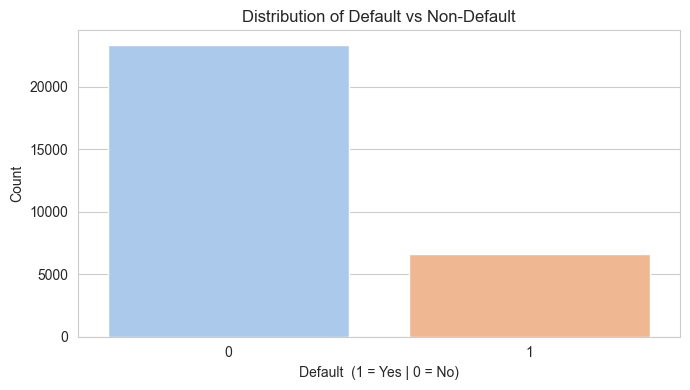

In [21]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.countplot(x='default payment next month', data=df, ax=ax, palette='pastel')
ax.set_title('Distribution of Default vs Non-Default')
ax.set_xlabel('Default  (1 = Yes | 0 = No)')
ax.set_ylabel('Count')
fig.tight_layout()
fig.savefig(OUTPUTS / '01_target_distribution.png', dpi=150)
plt.show()


── Correlations with target ──
default payment next month    1.000000
PAY_0                         0.324794
PAY_2                         0.263551
PAY_3                         0.235253
PAY_4                         0.216614
PAY_5                         0.204149
PAY_6                         0.186866
EDU_2                         0.036467
EDU_3                         0.032403
AGE                           0.013890
MAR_3                         0.004043
BILL_AMT6                    -0.004934
BILL_AMT4                    -0.010443
BILL_AMT3                    -0.011119
BILL_AMT2                    -0.012791
BILL_AMT5                    -0.013156
ID                           -0.013952
BILL_AMT1                    -0.024446
MAR_2                        -0.030619
SEX                          -0.039961
EDU_4                        -0.045703
PAY_AMT5                     -0.109828
PAY_AMT6                     -0.111352
PAY_AMT4                     -0.126043
PAY_AMT3                     -0.1

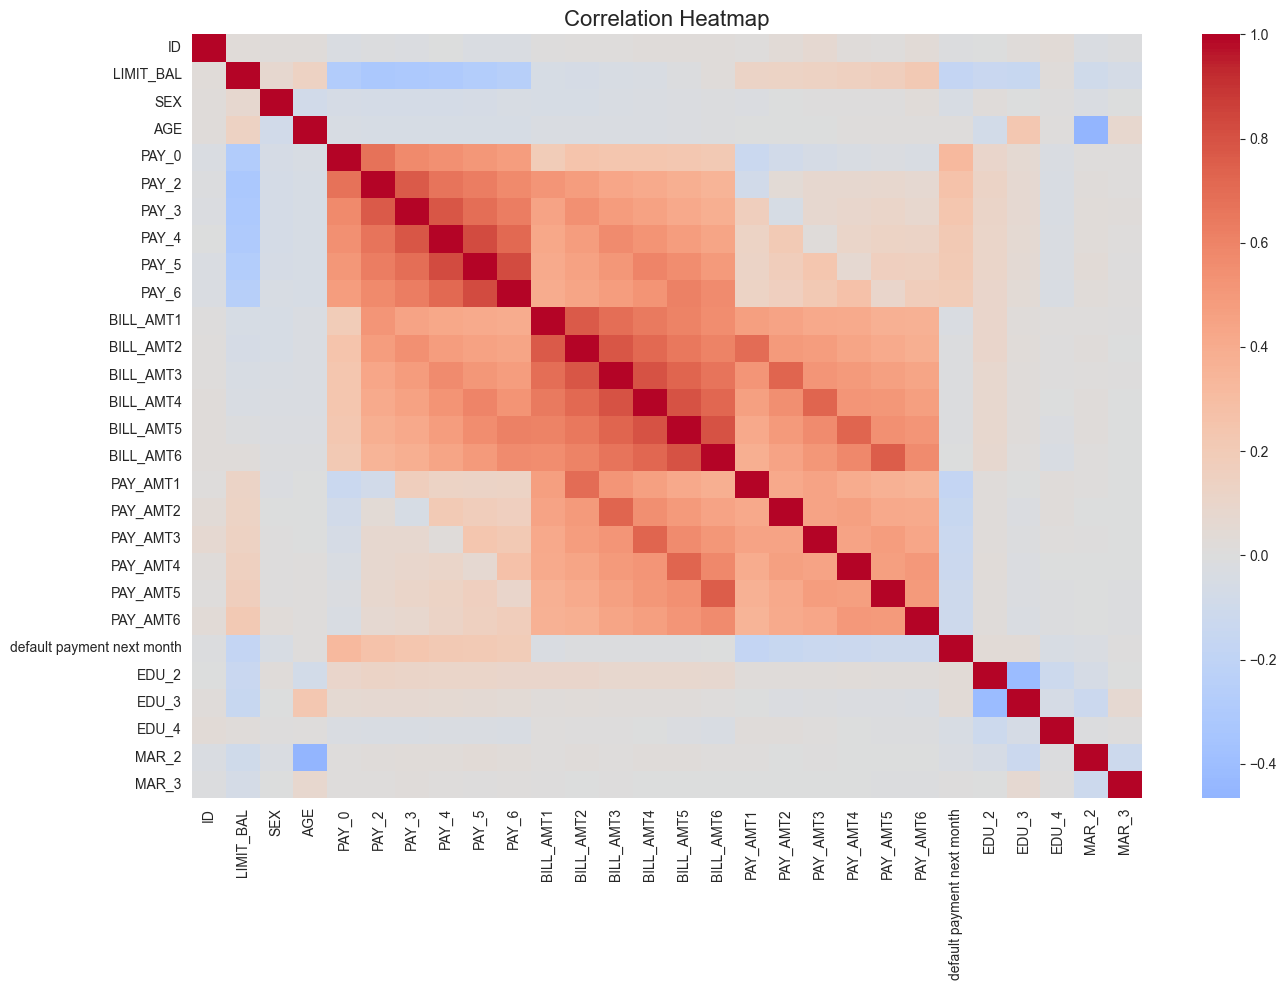

In [22]:
corr = df.corr(numeric_only=True)
target_corr = corr['default payment next month'].sort_values(ascending=False)

print('── Correlations with target ──')
print(target_corr.to_string())

fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False, ax=ax)
ax.set_title('Correlation Heatmap', fontsize=16)
fig.tight_layout()
fig.savefig(OUTPUTS / '02_full_correlation_heatmap.png', dpi=150)
plt.show()


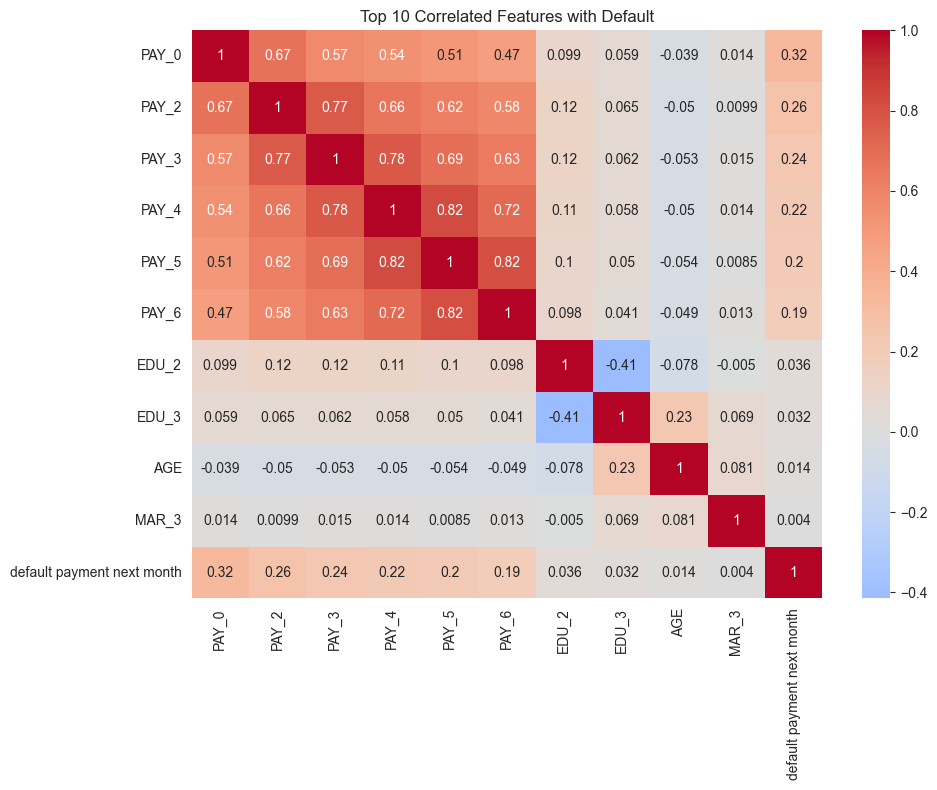

In [23]:
top_features = target_corr[1:11].index.tolist()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df[top_features + ['default payment next month']].corr(),
            annot=True, cmap='coolwarm', center=0, ax=ax)
ax.set_title('Top 10 Correlated Features with Default')
fig.tight_layout()
fig.savefig(OUTPUTS / '03_top10_correlation_heatmap.png', dpi=150)
plt.show()


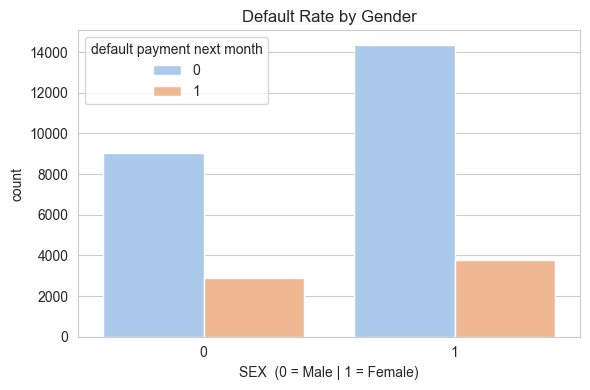

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(data=df, x='SEX', hue='default payment next month', palette='pastel', ax=ax)
ax.set_title('Default Rate by Gender')
ax.set_xlabel('SEX  (0 = Male | 1 = Female)')
fig.tight_layout()
fig.savefig(OUTPUTS / '04_sex_vs_default.png', dpi=150)
plt.show()


Default rate per age group:
AGE_BIN
20s    0.224
30s    0.204
40s    0.233
50s    0.252
60s    0.265
70s    0.333


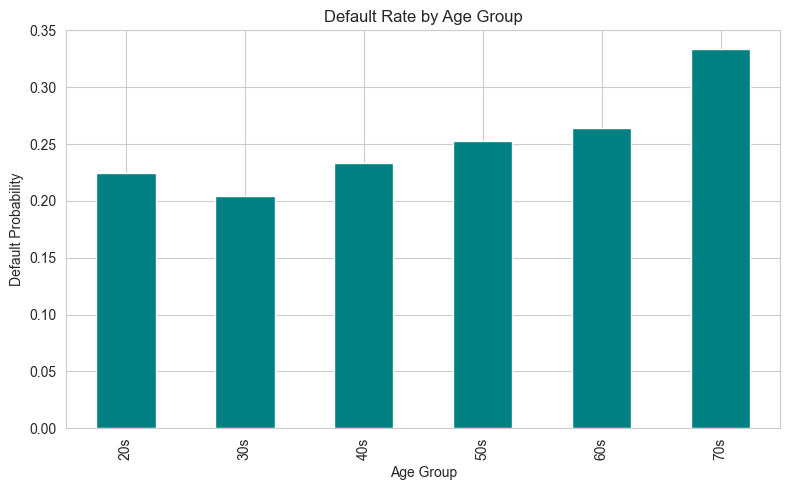

In [25]:
# Temporary column — not kept on df
temp = df.copy()
temp['AGE_BIN'] = pd.cut(temp['AGE'],
    bins=[20,30,40,50,60,70,80],
    labels=['20s','30s','40s','50s','60s','70s'])

age_default = temp.groupby('AGE_BIN', observed=True)['default payment next month'].mean()
print('Default rate per age group:')
print(age_default.round(3).to_string())

fig, ax = plt.subplots(figsize=(8, 5))
age_default.plot(kind='bar', color='teal', ax=ax)
ax.set_title('Default Rate by Age Group')
ax.set_ylabel('Default Probability')
ax.set_xlabel('Age Group')
fig.tight_layout()
fig.savefig(OUTPUTS / '05_age_group_default.png', dpi=150)
plt.show()


6. Feature Engineering

In [26]:
print(f'Columns BEFORE engineering: {df.shape[1]}')

# ── ratios (+1 avoids /0 on log-transformed denominators) ──
df['UTILIZATION_RATIO'] = df['BILL_AMT6'] / (df['LIMIT_BAL'] + 1)
df['PAYMENT_RATIO']     = df['PAY_AMT6']  / (df['BILL_AMT6']  + 1)
df['BALANCE_RATIO']     = (df['BILL_AMT6'] - df['PAY_AMT6']) / (df['LIMIT_BAL'] + 1)
df[['UTILIZATION_RATIO','PAYMENT_RATIO','BALANCE_RATIO']] = (
    df[['UTILIZATION_RATIO','PAYMENT_RATIO','BALANCE_RATIO']].replace([np.inf, -np.inf], 0))

# ── trends ──
df['BILL_TREND'] = df['BILL_AMT6'] - df['BILL_AMT1']
df['PAY_TREND']  = df['PAY_AMT6']  - df['PAY_AMT1']

# ── payment-history stats ──
pay_status = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
df['AVG_PAY_STATUS']  = df[pay_status].mean(axis=1)
df['PAY_VARIABILITY'] = df[pay_status].std(axis=1)

# ── age group ──
df['AGE_GROUP'] = pd.cut(df['AGE'],
    bins=[20, 30, 40, 50, 60, 80],
    labels=['20s','30s','40s','50s','60+'])

# ── duplicates ──
before = len(df)
df.drop_duplicates(inplace=True)
print(f'Duplicate rows removed: {before - len(df)}')

# ── one-hot AGE_GROUP ──
df = pd.get_dummies(df, columns=['AGE_GROUP'], drop_first=True)

print(f'Columns AFTER  engineering: {df.shape[1]}')

# Show the new features
eng = ['UTILIZATION_RATIO','PAYMENT_RATIO','BALANCE_RATIO',
       'BILL_TREND','PAY_TREND','AVG_PAY_STATUS','PAY_VARIABILITY']
df[eng].describe().round(3)


Columns BEFORE engineering: 28
Duplicate rows removed: 0
Columns AFTER  engineering: 39


,UTILIZATION_RATIO,PAYMENT_RATIO,BALANCE_RATIO,BILL_TREND,PAY_TREND,AVG_PAY_STATUS,PAY_VARIABILITY
count,30000.000,30000.000,30000.000,30000.000,30000.000,30000.000,30000.000
mean,0.650,0.797,0.184,-0.839,-0.697,-0.182,0.454
std,0.309,1.398,0.280,3.407,3.857,0.982,0.516
min,0.000,0.000,-0.981,-13.109,-12.912,-2.000,0.000
25%,0.553,0.487,0.000,-0.930,-1.283,-0.833,0.000
50%,0.789,0.654,0.217,-0.089,-0.251,0.000,0.408
75%,0.875,0.767,0.267,0.143,0.193,0.000,0.837
max,1.033,12.752,0.966,12.781,13.178,6.000,3.204


In [27]:
updated = df.corr(numeric_only=True)['default payment next month'].sort_values(ascending=False)

print('── Top 15 ──')
print(updated.head(15).to_string())
print('\n── Bottom 15 ──')
print(updated.tail(15).to_string())


── Top 15 ──
default payment next month    1.000000
PAY_0                         0.324794
AVG_PAY_STATUS                0.281955
PAY_2                         0.263551
PAY_VARIABILITY               0.248922
PAY_3                         0.235253
PAY_4                         0.216614
PAY_5                         0.204149
PAY_6                         0.186866
BALANCE_RATIO                 0.118170
PAY_TREND                     0.041654
EDU_2                         0.036467
EDU_3                         0.032403
UTILIZATION_RATIO             0.026174
AGE_GROUP_50s                 0.020060

── Bottom 15 ──
BILL_AMT5       -0.013156
ID              -0.013952
BILL_AMT1       -0.024446
AGE_GROUP_30s   -0.030290
MAR_2           -0.030619
SEX             -0.039961
EDU_4           -0.045703
PAYMENT_RATIO   -0.052598
PAY_AMT5        -0.109828
PAY_AMT6        -0.111352
PAY_AMT4        -0.126043
PAY_AMT3        -0.139197
PAY_AMT2        -0.150030
PAY_AMT1        -0.170300
LIMIT_BAL       -0.17

7. Train/Test Split and Scaling

In [28]:
target = 'default payment next month'

X = df.drop(columns=[target])
y = df[target]
feature_columns = X.columns.tolist()

print(f'Feature matrix : {X.shape}')
print(f'Target vector  : {y.shape}')
print(f'\nTarget balance:\n{y.value_counts()}')

# ── 80/20 stratified split ──
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f'\nTrain size: {X_train.shape[0]:,}   Test size: {X_test.shape[0]:,}')

# ── bool → int (get_dummies may produce bool on newer pandas) ──
for frame in (X_train, X_test):
    bcols = frame.select_dtypes(include='bool').columns
    if len(bcols):
        frame[bcols] = frame[bcols].astype(int)

# ── NaN check ──
print(f'\nNaNs BEFORE scaling — train: {X_train.isnull().sum().sum()},  test: {X_test.isnull().sum().sum()}')

# ── StandardScaler (fit on train only) ──
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test),      columns=X_test.columns,  index=X_test.index)

# Fill any NaN that appeared from inf during scaling
X_train_scaled.fillna(0, inplace=True)
X_test_scaled.fillna(0, inplace=True)

print(f'NaNs AFTER  scaling — train: {X_train_scaled.isnull().sum().sum()},  test: {X_test_scaled.isnull().sum().sum()}')

# ── class weights ──
classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, weights))
print(f'\nClass weights: {class_weights_dict}')

print('\n── Scaled feature sample ──')
X_train_scaled.head()


Feature matrix : (30000, 38)
Target vector  : (30000,)

Target balance:
default payment next month
0    23364
1     6636
Name: count, dtype: int64

Train size: 24,000   Test size: 6,000

NaNs BEFORE scaling — train: 0,  test: 0
NaNs AFTER  scaling — train: 0,  test: 0

Class weights: {np.int64(0): np.float64(0.6420202236370446), np.int64(1): np.float64(2.2603126765869277)}

── Scaled feature sample ──


,ID,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,PAYMENT_RATIO,BALANCE_RATIO,BILL_TREND,PAY_TREND,AVG_PAY_STATUS,PAY_VARIABILITY,AGE_GROUP_30s,AGE_GROUP_40s,AGE_GROUP_50s,AGE_GROUP_60+
22788,0.904395,0.340007,0.80844,-0.264558,1.793311,1.780193,2.652046,1.911811,0.240260,0.256087,...,-0.087668,0.245232,0.250070,-0.046909,1.721333,1.492227,1.337200,-0.497525,-0.265827,-0.094852
29006,1.623947,0.271348,0.80844,-0.155804,0.902944,-0.722324,-0.697642,-1.530826,-1.537252,-1.489963,...,-0.569351,-0.657300,0.247844,-0.847624,-1.005498,1.384084,1.337200,-0.497525,-0.265827,-0.094852
16950,0.228817,-2.609497,-1.23695,1.584260,0.902944,1.780193,0.139780,0.190493,0.240260,0.256087,...,-0.074740,0.085806,0.191805,1.692191,0.698772,0.738749,-0.747831,2.009950,-0.265827,-0.094852
22280,0.845609,0.678790,0.80844,-0.699574,0.012576,0.111849,0.139780,0.190493,0.240260,0.256087,...,-0.081323,0.176208,0.121372,0.078332,0.187491,-0.885650,-0.747831,-0.497525,-0.265827,-0.094852
11346,-0.419683,1.043629,0.80844,-0.373312,0.902944,-1.556496,-0.697642,0.190493,0.240260,-1.489963,...,4.525496,-2.510854,0.247844,2.024150,-0.494217,1.465657,1.337200,-0.497525,-0.265827,-0.094852


Baseline Models with MLFlow Tracking

In [29]:
# Calculate class weights for imbalanced data
classes = np.unique(y_train)
class_weights_array = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights_array))

print(f'Class weights: {class_weight_dict}')


Class weights: {np.int64(0): np.float64(0.6420202236370446), np.int64(1): np.float64(2.2603126765869277)}


In [30]:
# Define models to evaluate
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
]

results = []

print('Training baseline models and logging to MLflow...\n')

for name, model in models:
    # Start MLflow run
    with mlflow.start_run(run_name=f"baseline_{name.replace(' ', '_').lower()}"):
        print(f'├─ Training {name}...')
        
        # Train model
        model.fit(X_train_scaled, y_train)
        
        # Predictions
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        # Metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)
        
        # Log parameters
        mlflow.log_param("model_type", name)
        mlflow.log_param("n_features", X_train.shape[1])
        mlflow.log_param("train_size", X_train.shape[0])
        mlflow.log_param("test_size", X_test.shape[0])
        
        # Log model-specific params
        if hasattr(model, 'get_params'):
            for param, value in model.get_params().items():
                if isinstance(value, (int, float, str, bool)):
                    mlflow.log_param(param, value)
        
        # Log metrics
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("roc_auc", roc_auc)
        
        # Create and log confusion matrix plot
        cm = confusion_matrix(y_test, y_pred)
        fig, ax = plt.subplots(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f'Confusion Matrix - {name}')
        ax.set_ylabel('True')
        ax.set_xlabel('Predicted')
        plt.tight_layout()
        
        # Save and log the plot
        plot_path = OUTPUTS / f'cm_{name.replace(" ", "_").lower()}.png'
        fig.savefig(plot_path, dpi=150)
        mlflow.log_artifact(str(plot_path))
        plt.close()
        
        # Log the model with signature
        signature = infer_signature(X_train_scaled, y_pred)
        mlflow.sklearn.log_model(model, "model", signature=signature)
        
        # Store results
        results.append({
            'Model': name,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-Score': f1,
            'ROC-AUC': roc_auc
        })
        
        print(f'   ✓ Logged to MLflow (ROC-AUC: {roc_auc:.4f})\n')

# Create results DataFrame
results_df = pd.DataFrame(results).set_index('Model')
print('\n' + '='*70)
print('BASELINE MODEL RESULTS')
print('='*70)
print(results_df.to_string())
print('='*70)


Training baseline models and logging to MLflow...

├─ Training Logistic Regression...


2026/02/07 11:30:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
c:\Users\BEST\Documents\Default_Credit_Card_Clients\venv\Lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


   ✓ Logged to MLflow (ROC-AUC: 0.7389)

├─ Training Random Forest...


2026/02/07 11:31:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
c:\Users\BEST\Documents\Default_Credit_Card_Clients\venv\Lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


   ✓ Logged to MLflow (ROC-AUC: 0.7736)

├─ Training Gradient Boosting...


2026/02/07 11:31:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
c:\Users\BEST\Documents\Default_Credit_Card_Clients\venv\Lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


   ✓ Logged to MLflow (ROC-AUC: 0.7792)


BASELINE MODEL RESULTS
                     Accuracy  Precision    Recall  F1-Score   ROC-AUC
Model                                                                 
Logistic Regression  0.729000   0.423529  0.623964  0.504570  0.738941
Random Forest        0.786333   0.515614  0.559910  0.536850  0.773624
Gradient Boosting    0.820667   0.672154  0.369254  0.476654  0.779198


Best Model Selection and Feature Importance


 Best Model: Gradient Boosting
   ROC-AUC: 0.7792

Top 10 Feature Importances:
PAY_0              0.546093
AVG_PAY_STATUS     0.185332
PAY_VARIABILITY    0.041806
BILL_AMT1          0.034187
LIMIT_BAL          0.022328
PAY_2              0.021389
PAY_AMT3           0.018260
PAY_AMT2           0.016348
BILL_TREND         0.014894
ID                 0.009369


C:\Users\BEST\AppData\Local\Temp\ipykernel_15724\2273324442.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.head(10).values, y=importances.head(10).index, ax=ax, palette='viridis')


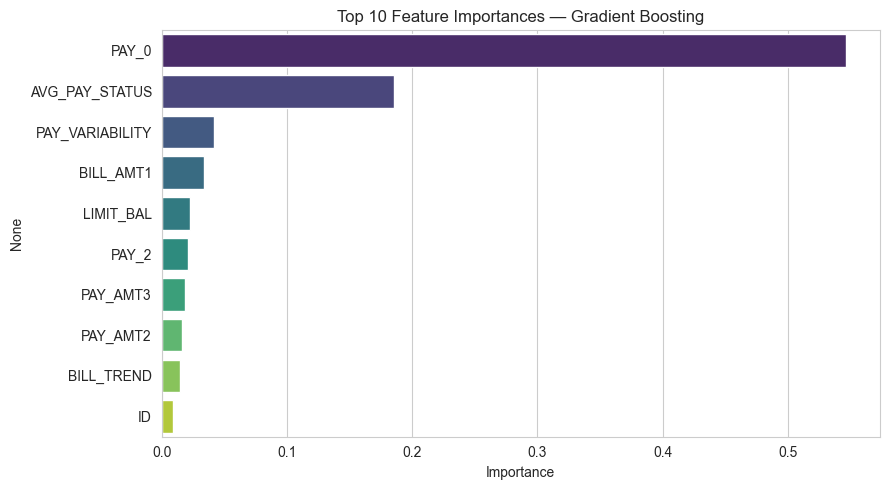

In [31]:
# Select best model by ROC-AUC
best_model_name = results_df['ROC-AUC'].idxmax()
best_model_idx = [name for name, _ in models].index(best_model_name)
best_model = models[best_model_idx][1]

print(f'\n Best Model: {best_model_name}')
print(f'   ROC-AUC: {results_df.loc[best_model_name, "ROC-AUC"]:.4f}')

# Feature importance
feature_columns = X_train.columns

if hasattr(best_model, 'feature_importances_'):
    importances = pd.Series(best_model.feature_importances_, index=feature_columns).sort_values(ascending=False)
    print('\nTop 10 Feature Importances:')
    print(importances.head(10).to_string())

    fig, ax = plt.subplots(figsize=(9, 5))
    sns.barplot(x=importances.head(10).values, y=importances.head(10).index, ax=ax, palette='viridis')
    ax.set_title(f'Top 10 Feature Importances — {best_model_name}')
    ax.set_xlabel('Importance')
    fig.tight_layout()
    fig.savefig(OUTPUTS / '07_feature_importance.png', dpi=150)
    plt.show()

elif hasattr(best_model, 'coef_'):
    coefs = pd.Series(best_model.coef_[0], index=feature_columns).sort_values(key=abs, ascending=False)
    print('\nTop 10 Feature Coefficients:')
    print(coefs.head(10).to_string())

    fig, ax = plt.subplots(figsize=(9, 5))
    sns.barplot(x=coefs.head(10).values, y=coefs.head(10).index, ax=ax, palette='viridis')
    ax.set_title(f'Top 10 Feature Coefficients — {best_model_name}')
    ax.set_xlabel('Coefficient')
    fig.tight_layout()
    fig.savefig(OUTPUTS / '07_feature_importance.png', dpi=150)
    plt.show()


Threshold Optimisation with MLFlow

In [32]:
with mlflow.start_run(run_name="threshold_optimization"):
    y_probs = best_model.predict_proba(X_test_scaled)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

    best_idx       = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1        = f1_scores[best_idx]

    print(f'Optimal Threshold : {best_threshold:.4f}')
    print(f'Best F1 at that threshold: {best_f1:.4f}')

    # Log to MLflow
    mlflow.log_param("base_model", best_model_name)
    mlflow.log_metric("optimal_threshold", best_threshold)
    mlflow.log_metric("best_f1_threshold", best_f1)

    # ── apply & re-evaluate ──
    y_pred_opt = (y_probs >= best_threshold).astype(int)

    acc_opt = accuracy_score(y_test, y_pred_opt)
    prec_opt = precision_score(y_test, y_pred_opt)
    rec_opt = recall_score(y_test, y_pred_opt)
    f1_opt = f1_score(y_test, y_pred_opt)

    mlflow.log_metric("accuracy_optimized", acc_opt)
    mlflow.log_metric("precision_optimized", prec_opt)
    mlflow.log_metric("recall_optimized", rec_opt)
    mlflow.log_metric("f1_optimized", f1_opt)

    print(f'\n── Classification Report  (threshold = {best_threshold:.2f}) ──')
    print(classification_report(y_test, y_pred_opt))

    print('── Confusion Matrix ──')
    print(confusion_matrix(y_test, y_pred_opt))


Optimal Threshold : 0.2981
Best F1 at that threshold: 0.5430

── Classification Report  (threshold = 0.30) ──
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4673
           1       0.55      0.54      0.54      1327

    accuracy                           0.80      6000
   macro avg       0.71      0.71      0.71      6000
weighted avg       0.80      0.80      0.80      6000

── Confusion Matrix ──
[[4087  586]
 [ 614  713]]


Gradient boosting - Hyperparameter Tuning

Tuned model evaluation

In [ ]:
#param_dist = {
#   'n_estimators'     : randint(100, 400),
#    'learning_rate'    : uniform(0.01, 0.1),
 #   'max_depth'        : randint(2, 5),
  #  'subsample'        : uniform(0.8, 0.2),
   # 'min_samples_split': randint(2, 10),
#}

#with mlflow.start_run(run_name="hyperparameter_tuning_gb"):
 #   mlflow.log_param("tuning_method", "RandomizedSearchCV")
  #  mlflow.log_param("n_iter", 30)
   # mlflow.log_param("cv_folds", 3)
    #mlflow.log_param("scoring", "f1")
    
    #random_search = RandomizedSearchCV(
     #   estimator=GradientBoostingClassifier(random_state=42),
     #   param_distributions=param_dist,
     #   n_iter=30, scoring='f1', cv=3,
     #   n_jobs=-1, random_state=42, verbose=1)

    #print('Starting RandomizedSearchCV ...\n')
    #random_search.fit(X_train_scaled, y_train)

    #print('\nBest Parameters:')
    #for k, v in random_search.best_params_.items():
     #   print(f'  {k:25s}: {v}')
     #   mlflow.log_param(f"best_{k}", v)
    
    #mlflow.log_metric("best_cv_f1_score", random_search.best_score_)


In [40]:
from scipy.stats import uniform, randint

# Balanced search space (good results + reasonable time)
param_dist = {
    'n_estimators'     : randint(75, 200),      
    'learning_rate'    : uniform(0.03, 0.07),   
    'max_depth'        : randint(2, 5),         
    'subsample'        : uniform(0.8, 0.2),     
    'min_samples_split': randint(2, 8),         
}


print(f'  Parameters to tune: {list(param_dist.keys())}')

  Parameters to tune: ['n_estimators', 'learning_rate', 'max_depth', 'subsample', 'min_samples_split']


In [43]:

print('  HYPERPARAMETER TUNING ')


with mlflow.start_run(run_name="hyperparameter_tuning_gb_balanced"):
    # Log tuning configuration
    mlflow.log_param("tuning_method", "RandomizedSearchCV")
    mlflow.log_param("n_iter", 10)
    mlflow.log_param("cv_folds", 3)
    mlflow.log_param("scoring", "f1")
    mlflow.log_param("mode", "balanced")
    
    # Create search object
    random_search = RandomizedSearchCV(
        estimator=GradientBoostingClassifier(random_state=42),
        param_distributions=param_dist,
        n_iter=10,         # 10 iterations
        scoring='f1', 
        cv=3,              # 3-fold CV
        n_jobs=-1, 
        random_state=42, 
        verbose=1)


    
    # Run the search 
    random_search.fit(X_train_scaled, y_train)

    # Log best parameters
    print('\n Tuning Complete!')
    print('\nBest Parameters Found:')
    for k, v in random_search.best_params_.items():
        print(f'  {k:25s}: {v}')
        mlflow.log_param(f"best_{k}", v)
    
    # Log best CV score
    mlflow.log_metric("best_cv_f1_score", random_search.best_score_)
    print(f'\nBest CV F1 Score: {random_search.best_score_:.4f}')

  HYPERPARAMETER TUNING 
Fitting 3 folds for each of 10 candidates, totalling 30 fits

 Tuning Complete!

Best Parameters Found:
  learning_rate            : 0.050386039813862936
  max_depth                : 4
  min_samples_split        : 3
  n_estimators             : 166
  subsample                : 0.9947511037682919

Best CV F1 Score: 0.4776


In [44]:

print('  EVALUATING TUNED MODEL ON TEST SET')


# Extract the best model
best_gb = random_search.best_estimator_

# Make predictions on test set
y_pred_tuned = best_gb.predict(X_test_scaled)
y_proba_tuned = best_gb.predict_proba(X_test_scaled)[:, 1]

print('Predictions generated')

  EVALUATING TUNED MODEL ON TEST SET
Predictions generated


In [45]:
# Calculate all metrics
acc_tuned = accuracy_score(y_test, y_pred_tuned)
prec_tuned = precision_score(y_test, y_pred_tuned)
rec_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
roc_auc_tuned = roc_auc_score(y_test, y_proba_tuned)

# Calculate improvement over baseline
baseline_roc = results_df.loc[best_model_name, 'ROC-AUC']
improvement = ((roc_auc_tuned - baseline_roc) / baseline_roc) * 100

print(' Metrics calculated')
print(f'  ROC-AUC: {roc_auc_tuned:.4f}')
print(f'  Improvement over baseline: {improvement:+.2f}%')

 Metrics calculated
  ROC-AUC: 0.7805
  Improvement over baseline: +0.17%


In [46]:
with mlflow.start_run(run_name="tuned_gradient_boosting_balanced"):
    
    # ── Log Parameters ──
    mlflow.log_param("model_type", "Gradient Boosting (Tuned)")
    mlflow.log_param("tuning_mode", "balanced")
    mlflow.log_param("search_iterations", 10)
    mlflow.log_param("cv_folds", 3)
    mlflow.log_param("n_features", X_train.shape[1])
    mlflow.log_param("train_size", X_train.shape[0])
    mlflow.log_param("test_size", X_test.shape[0])
    
    # Log best hyperparameters
    for k, v in random_search.best_params_.items():
        mlflow.log_param(k, v)
    
    # ── Log Metrics ──
    mlflow.log_metric("accuracy", acc_tuned)
    mlflow.log_metric("precision", prec_tuned)
    mlflow.log_metric("recall", rec_tuned)
    mlflow.log_metric("f1_score", f1_tuned)
    mlflow.log_metric("roc_auc", roc_auc_tuned)
    mlflow.log_metric("cv_f1_score", random_search.best_score_)
    mlflow.log_metric("improvement_over_baseline_pct", improvement)
    
    # ── Log Model ──
    signature = infer_signature(X_train_scaled, y_pred_tuned)
    mlflow.sklearn.log_model(
        best_gb, 
        "model", 
        signature=signature,
        input_example=X_train_scaled[:5]
    )
    
    print(' logged to MLflow')

2026/02/07 12:34:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
c:\Users\BEST\Documents\Default_Credit_Card_Clients\venv\Lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


 logged to MLflow


In [47]:
print('  TUNED MODEL RESULTS')


print('\n✓ Best Parameters:')
for k, v in random_search.best_params_.items():
    print(f'  {k:25s}: {v}')

print(f'\n── Performance Metrics ──')
print(f'  Accuracy  : {acc_tuned:.4f}')
print(f'  Precision : {prec_tuned:.4f}')
print(f'  Recall    : {rec_tuned:.4f}')
print(f'  F1 Score  : {f1_tuned:.4f}')
print(f'  ROC-AUC   : {roc_auc_tuned:.4f}')

print(f'\n── Comparison to Baseline ({best_model_name}) ──')
print(f'  Baseline ROC-AUC  : {baseline_roc:.4f}')
print(f'  Tuned ROC-AUC     : {roc_auc_tuned:.4f}')
print(f'  Improvement       : {improvement:+.2f}%')

print(f'\n── Classification Report ──')
print(classification_report(y_test, y_pred_tuned))

print(f'\n── Confusion Matrix ──')
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
print(cm_tuned)

  TUNED MODEL RESULTS

✓ Best Parameters:
  learning_rate            : 0.050386039813862936
  max_depth                : 4
  min_samples_split        : 3
  n_estimators             : 166
  subsample                : 0.9947511037682919

── Performance Metrics ──
  Accuracy  : 0.8185
  Precision : 0.6626
  Recall    : 0.3655
  F1 Score  : 0.4711
  ROC-AUC   : 0.7805

── Comparison to Baseline (Gradient Boosting) ──
  Baseline ROC-AUC  : 0.7792
  Tuned ROC-AUC     : 0.7805
  Improvement       : +0.17%

── Classification Report ──
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.66      0.37      0.47      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.66      0.68      6000
weighted avg       0.80      0.82      0.80      6000


── Confusion Matrix ──
[[4426  247]
 [ 842  485]]


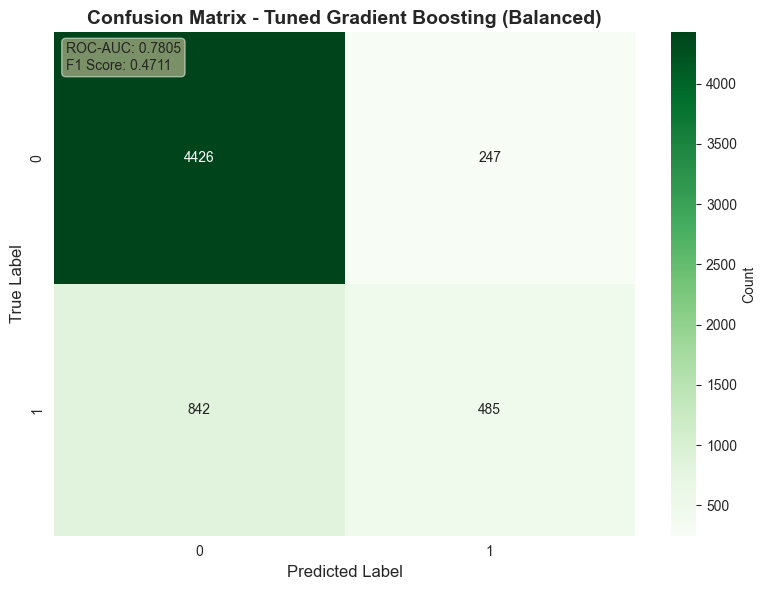

In [48]:
with mlflow.start_run(run_name="tuned_gradient_boosting_balanced"):
    
    # Create confusion matrix plot
    fig, ax = plt.subplots(figsize=(8, 6))
    cm_tuned = confusion_matrix(y_test, y_pred_tuned)
    
    sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens', ax=ax, 
                cbar_kws={'label': 'Count'})
    ax.set_title('Confusion Matrix - Tuned Gradient Boosting (Balanced)', 
                 fontsize=14, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)
    
    # Add performance metrics to plot
    textstr = f'ROC-AUC: {roc_auc_tuned:.4f}\nF1 Score: {f1_tuned:.4f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    
    # Save and log to MLflow
    plot_path = OUTPUTS / 'cm_tuned_gb_balanced.png'
    fig.savefig(plot_path, dpi=150, bbox_inches='tight')
    mlflow.log_artifact(str(plot_path))
    
    plt.show()

In [49]:
with mlflow.start_run(run_name="tuned_gradient_boosting_balanced"):
    
    if hasattr(best_gb, 'feature_importances_'):
        # Create feature importance dataframe
        importances = pd.DataFrame({
            'feature': X_train.columns,
            'importance': best_gb.feature_importances_
        }).sort_values('importance', ascending=False)
        
        # Save as CSV
        importance_path = OUTPUTS / 'feature_importance_tuned_gb.csv'
        importances.to_csv(importance_path, index=False)
        mlflow.log_artifact(str(importance_path))
        
        # Display top 10
        print('\n── Top 10 Feature Importances ──')
        print(importances.head(10).to_string(index=False))
        print('\n Feature importance logged')
    else:
        print('\ Model does not have feature_importances_')


print('Tuned model fully logged to MLflow')


── Top 10 Feature Importances ──
        feature  importance
          PAY_0    0.508802
 AVG_PAY_STATUS    0.138326
PAY_VARIABILITY    0.041261
      BILL_AMT1    0.036526
          PAY_2    0.035960
      LIMIT_BAL    0.028256
     BILL_TREND    0.020581
       PAY_AMT3    0.019886
             ID    0.018628
       PAY_AMT2    0.016881

 Feature importance logged
Tuned model fully logged to MLflow


<>:20: SyntaxWarning: "\ " is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\ "? A raw string is also an option.
<>:20: SyntaxWarning: "\ " is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\ "? A raw string is also an option.
C:\Users\BEST\AppData\Local\Temp\ipykernel_15724\1208000713.py:20: SyntaxWarning: "\ " is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\ "? A raw string is also an option.
  print('\ Model does not have feature_importances_')


Summary

In [51]:
print('  PIPELINE COMPLETE')

print(f'  Best baseline      : {best_model_name}')
print(f'  Baseline ROC-AUC   : {results_df.loc[best_model_name, "ROC-AUC"]:.4f}')
print(f'  Optimal threshold  : {best_threshold:.4f}')
print(f'  F1 @ opt threshold : {best_f1:.4f}')
print(f'  Tuned GB ROC-AUC   : {roc_auc_tuned:.4f}')

print(f'   Then open: http://localhost:5000')



  PIPELINE COMPLETE
  Best baseline      : Gradient Boosting
  Baseline ROC-AUC   : 0.7792
  Optimal threshold  : 0.2981
  F1 @ opt threshold : 0.5430
  Tuned GB ROC-AUC   : 0.7805
   Then open: http://localhost:5000
